# Eye-Blink Detection
This notebook is an exploratory analysis of some preliminary data for the 2021-2022 weeping angel car project. This is our testing space for trying out different analysis approaches.

## Preliminary Analysis

Our goals for the analysis are:
1. Detect normal eyeblinks
2. Detect normal eyeblinks from only the first 0.5 seconds of a blink
3. Separate normal eyeblinks from driving eye blinks
4. Detect which eye the eyeblinks are coming from

### Dataset Description

The following is a description of the recordings that are tested throughout this notebook.

- **Matt/Blinks_60s_BlinkEvery5s**: Recorded November 11, 2021 in Thode Basement, on Alex's laptop. The Muse was used without any additional hat or headband to hold it in place. Matt blinked once with both eyes every 5 seconds for a minute.

- **Matt/DrivingBlinksLeftEye_120s_BlinkEvery10sFor2s**: Recorded November 11, 2021 in Thode Basement, on Alex's laptop. The Muse was used without any additional hat or headband to hold it in place. Matt forcefully closed his left eye for 2s, then kept it open for 8s. The whole time, he was blinking normally and comfortably with both eyes.

- **Matt/DrivingBlinksLeftEye_120s_BlinkEvery10sFor2s**: Recorded November 11, 2021 in Thode Basement, on Alex's laptop. The Muse was used without any additional hat or headband to hold it in place. Matt forcefully closed his right eye for 2s, then kept it open for 8s. The whole time, he was blinking normally and comfortably with both eyes.

- **Alex/LeftDrivingBlinks_WithHat_ClosedRight_5s**: Recorded November 26, 2021 at Alex's house, on Alex's laptop. The muse was used with a hat to hold it in place. Alex held his right eye closed, and winked his left eye every 5s.

- **Alex/RightDrivingBlinks_WithHat_ClosedLeft_5s**: Recorded November 26, 2021 at Alex's house, on Alex's laptop. The muse was used with a hat to hold it in place. Alex held his left eye closed, and winked his right eye every 5s.

### Loading in the Data and Labelling Eyeblinks
We want to load in the data and prepare it to be analyzed. To do this, we'll store the actual values in pandas dataframes, which are python data structures that resemble spreadsheets, and are frequently used to store lots of tabular data. These dataframes really store the actual data inside a numpy array.

Once we have the data, we'll want to load it into MNE, by using it to initialize a RawData object in MNE.

Finally, we want to separate the eyeblinks so that we know which stretches of time contain eyeblinks, and which don't. Earlier versions of this notebook used a crude thresholding approach for recognizing eyeblinks in general (see github if you're interested), but in this version We'll do this using the built-in MNE functionality for detecting blinks.

In [2]:
# Load in the data as pandas dataframes
import pandas as pd
# Keep a dictionary so we can index each dataset by name
raw_recordings = {
                # Original datasets with hard-blink for driving blinks
                # "Matt_NormalBlinks": pd.read_csv("Data/Matt/Blinks_60s_BlinkEvery5s.csv"), 
                # "Matt_DrivingBlinksLeft": pd.read_csv("Data/Matt/DrivingBlinksLeftEye_120s_BlinkEvery10sFor2s.csv").iloc[:-500], 
                # "Matt_DrivingBlinksRight": pd.read_csv("Data/Matt/DrivingBlinksRightEye_120s_BlinkEvery10sFor2s.csv"),
                # # Improved dataset using a hat to hold the Muse down, and isolating winks in separate files
                # "Alex_LeftWinkWithHat": pd.read_csv("Data/Alex/LeftDrivingBlinks_WithHat_ClosedRight_5s.csv"), 
                # "Alex_RightWinkWithHat": pd.read_csv("Data/Alex/RightDrivingBlinks_WithHat_ClosedLeft_5s.csv"),
                # # datasets with alternating winks to improve realism of the signal
                # "Alex_AlternatingWinks_1": pd.read_csv("Data/Alex/Alex_AlternatingWinks_30s_1.csv"),
                # "Alex_AlternatingWinks_2": pd.read_csv("Data/Alex/Alex_AlternatingWinks_30s_2.csv"),
                # "Alex_AlternatingWinks_3": pd.read_csv("Data/Alex/Alex_AlternatingWinks_30s_3.csv"),
                # "Alex_AlternatingWinks_4": pd.read_csv("Data/Alex/Alex_AlternatingWinks_30s_4.csv"),
                # "Alex_NormalBlinks_1": pd.read_csv("Data/Alex/Alex_NormalBlinks_60s_1.csv"),
                # "Sabrina_AlternatingWinks_1": pd.read_csv("Data/Sabrina/Sabrina_AlternatingWinks_60s_1.csv"),
                # "Sabrina_AlternatingWinks_2": pd.read_csv("Data/Sabrina/Sabrina_AlternatingWinks_60s_2.csv"),
                # "Sabrina_NormalBlinks_1": pd.read_csv("Data/Sabrina/Sabrina_NormalBlinks_60s_1.csv"),
                # "Amanda_AlternatingWinks_1": pd.read_csv("Data/Amanda/Amanda_AlternatingWinks_60s_1.csv"),
                # "Amanda_AlternatingWinks_2": pd.read_csv("Data/Amanda/Amanda_AlternatingWinks_60s_2.csv"),
                # "Amanda_NormalBlinks_1": pd.read_csv("Data/Amanda/Amanda_NormalBlinks_60s_1.csv"),
                # Improved version of the hat data
                "Alex_LeftWinks_60s_2s": pd.read_csv("Data/Alex/Alex_LeftWinks_60s_2s_1.csv"),
                "Alex_RightWinks_60s_2s": pd.read_csv("Data/Alex/Alex_RightWinks_60s_2s_1.csv"),
                "Alex_NormalBlinks_60s_2s": pd.read_csv("Data/Alex/Alex_NormalBlinks_60s_2s_1.csv"),
                "Alex_FewBlinks_60s_5s": pd.read_csv("Data/Alex/Alex_FewBlinks_60s_5s_1.csv")
                }
# Print the head of the dataframes so we can verify that it imported properly
for key in raw_recordings.keys():
    print(f"\n{key}")
    print(raw_recordings[key].head())


Alex_LeftWinks_60s_2s
     timestamps     TP9     AF7     AF8    TP10  Right AUX
0  1.642356e+09  16.113  31.738  30.762  26.855     12.207
1  1.642356e+09  12.695  29.785  36.133  32.227     43.945
2  1.642356e+09  12.207  32.227  37.598  18.555     36.621
3  1.642356e+09  19.531  34.180  32.227  15.137    -15.625
4  1.642356e+09  15.625  31.738  27.832  16.113     42.969

Alex_RightWinks_60s_2s
     timestamps     TP9     AF7     AF8    TP10  Right AUX
0  1.642356e+09   1.953  29.785  27.832   7.812    -20.996
1  1.642356e+09  18.555  26.855  29.785  19.531     37.109
2  1.642356e+09  29.297  31.738  37.109  36.133     67.383
3  1.642356e+09  36.133  37.598  35.156  35.156     18.066
4  1.642356e+09  27.832  32.715  39.062  23.926     41.016

Alex_NormalBlinks_60s_2s
     timestamps     TP9     AF7     AF8    TP10  Right AUX
0  1.642357e+09  24.902  31.250  26.367  25.879     28.320
1  1.642357e+09  31.250  28.809  25.879  24.414    -16.113
2  1.642357e+09  31.250  30.762  26.367  2

Now, we are ready to create the MNE objects that we'll use for the rest of the analysis:

In [3]:
# Import MNE
import mne
# Tell MNE to not bother us with outputs unless something's wrong
mne.set_log_level("WARNING")

# Create the info object that stores our metadata
info = mne.create_info(["timestamps","TP9","AF7","AF8", "TP10", "Right AUX"], 256, ch_types="eeg")

# Create the MNE raw data object using the raw data (.values.T to extract the values only, and transpose to make it in the format MNE wants)
raw_data = {dataset_name : mne.io.RawArray(raw_recordings[dataset_name].values.T/1000000, info) for dataset_name in raw_recordings.keys()}
#notchfiltered_data = {raw_data[dataset_name].notch_filter([60, 120], picks=["TP9","AF7","AF8", "TP10"]) for dataset_name in raw_data.keys()}
#bandpassfiltered_data = {raw_data[dataset_name].filter(20, 50, picks=["TP9","AF7","AF8", "TP10"], method="fir") for dataset_name in raw_data.keys()}

# Create the MNE Epochs object using the Blink column
epoched_data = {dataset_name: mne.preprocessing.create_eog_epochs(raw_data[dataset_name], ch_name=["TP9","AF7","AF8", "TP10"]) for dataset_name in raw_recordings.keys()}

# Create the MNE Evoked object using the epochs
evoked_data = {dataset_name : epoched.average(picks="all") for dataset_name, epoched in epoched_data.items()}

## Checking the Dataset

Let's do some checks to see if the data as a whole contains a reliable blink-signal that we can try to detect. Let's start with the power spectral densities to see if we have any weird signals. 

C:\Users\Alex\AppData\Local\Temp\ipykernel_13232\4019749504.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  data.plot_psd(picks=["AF7","AF8","TP9","TP10"])


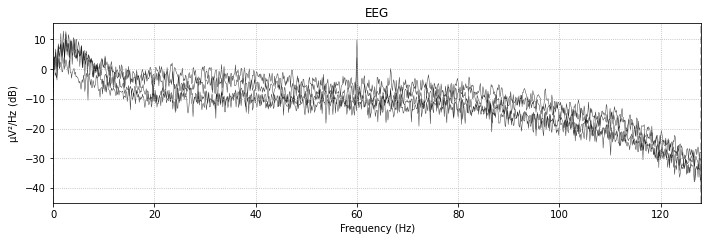

C:\Users\Alex\AppData\Local\Temp\ipykernel_13232\4019749504.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  data.plot_psd(picks=["AF7","AF8","TP9","TP10"])


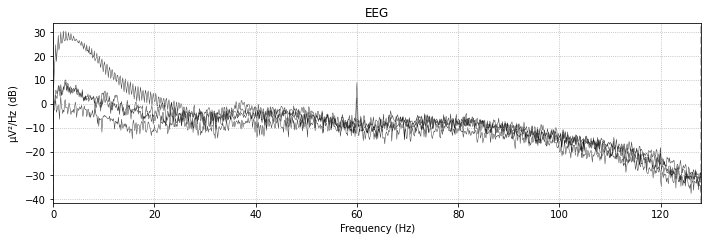

C:\Users\Alex\AppData\Local\Temp\ipykernel_13232\4019749504.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  data.plot_psd(picks=["AF7","AF8","TP9","TP10"])


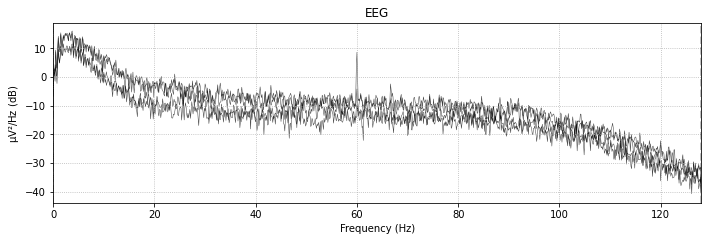

C:\Users\Alex\AppData\Local\Temp\ipykernel_13232\4019749504.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  data.plot_psd(picks=["AF7","AF8","TP9","TP10"])


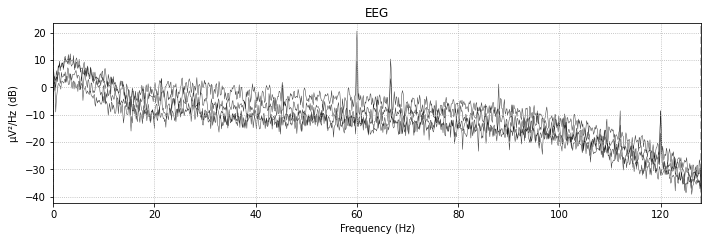

In [5]:
# Plot the PSDs of the data so we can see what the frequency content is like.
for key, data in raw_data.items():
    data.plot_psd(picks=["AF7","AF8","TP9","TP10"])

As expected, some of the datasets (especially Matt's, which were recorded in Thode basement) have some significant 60 Hz signal. Some of this is due to power line noise, but some of it is actual eyeblink signal. The eyeblink signals last about 1s, meaning they have significant 60 Hz contribution, and filtering out the powerline noise would remove them as well.

There are definitely also some strange features to these plots that should be investigated:
- What's causing those waves in the plots?

Let's visualize the epochs and see if we can notice any patterns in the averaged-out eyeblinks.

C:\Users\ryanp\AppData\Local\Temp\ipykernel_10688\3333842092.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")


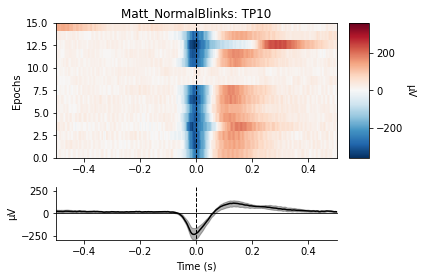

C:\Users\ryanp\AppData\Local\Temp\ipykernel_10688\3333842092.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")


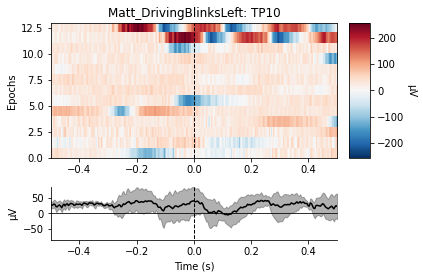

C:\Users\ryanp\AppData\Local\Temp\ipykernel_10688\3333842092.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")


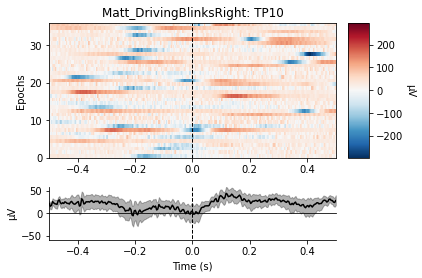

C:\Users\ryanp\AppData\Local\Temp\ipykernel_10688\3333842092.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")


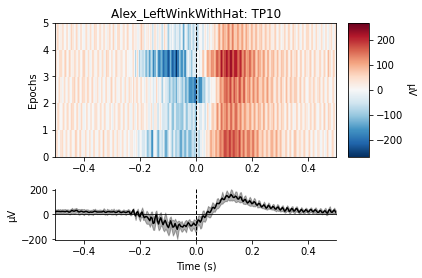

C:\Users\ryanp\AppData\Local\Temp\ipykernel_10688\3333842092.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")


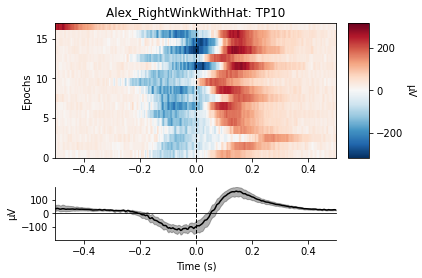

C:\Users\ryanp\AppData\Local\Temp\ipykernel_10688\3333842092.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")


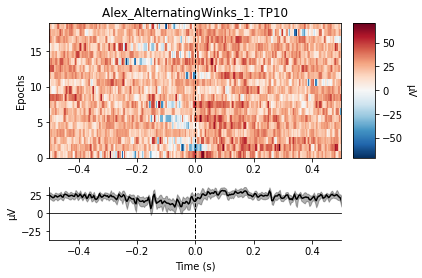

C:\Users\ryanp\AppData\Local\Temp\ipykernel_10688\3333842092.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")


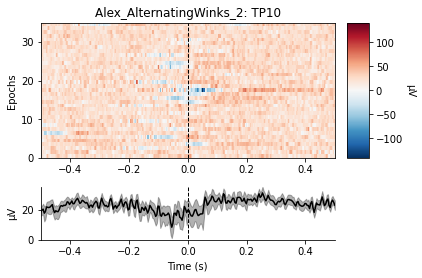

C:\Users\ryanp\AppData\Local\Temp\ipykernel_10688\3333842092.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")


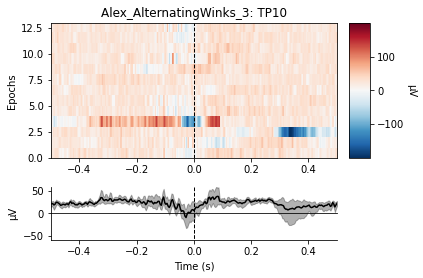

C:\Users\ryanp\AppData\Local\Temp\ipykernel_10688\3333842092.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")


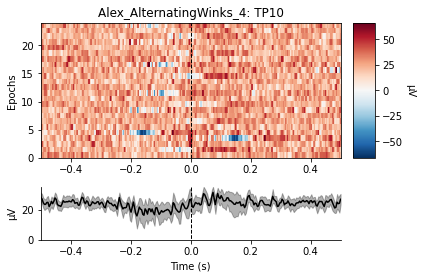

C:\Users\ryanp\AppData\Local\Temp\ipykernel_10688\3333842092.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")


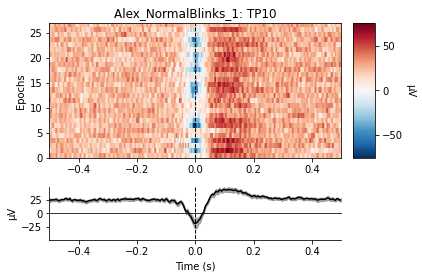

C:\Users\ryanp\AppData\Local\Temp\ipykernel_10688\3333842092.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")


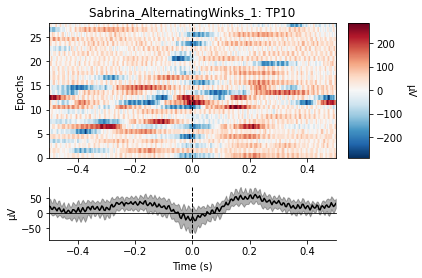

C:\Users\ryanp\AppData\Local\Temp\ipykernel_10688\3333842092.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")


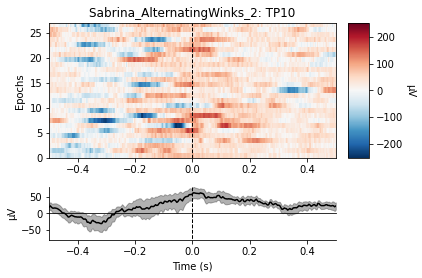

C:\Users\ryanp\AppData\Local\Temp\ipykernel_10688\3333842092.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")


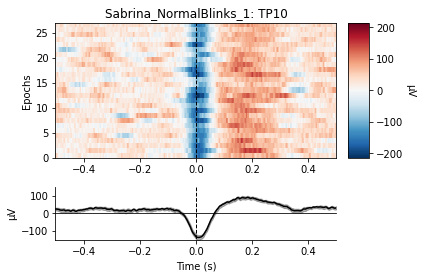

C:\Users\ryanp\AppData\Local\Temp\ipykernel_10688\3333842092.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")


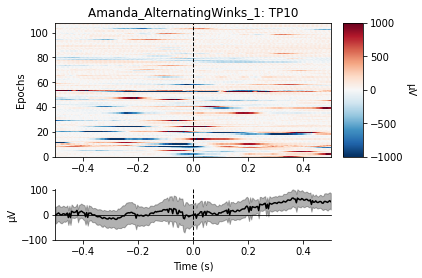

C:\Users\ryanp\AppData\Local\Temp\ipykernel_10688\3333842092.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")


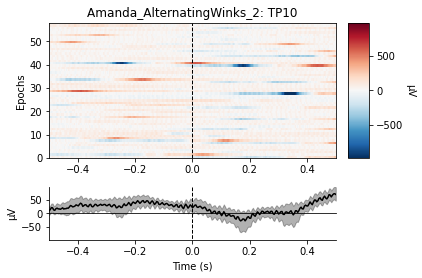

C:\Users\ryanp\AppData\Local\Temp\ipykernel_10688\3333842092.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")


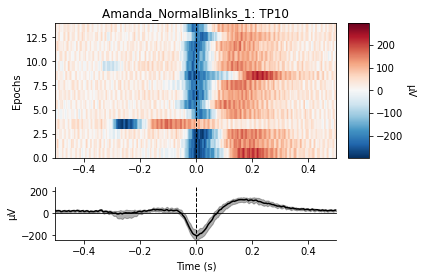

C:\Users\ryanp\AppData\Local\Temp\ipykernel_10688\3333842092.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")


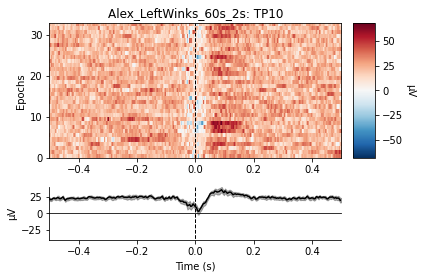

C:\Users\ryanp\AppData\Local\Temp\ipykernel_10688\3333842092.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")


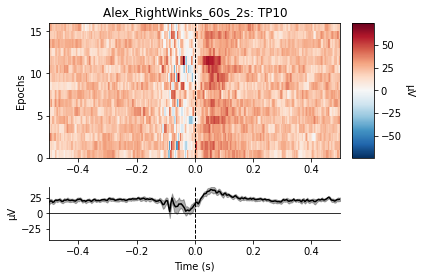

C:\Users\ryanp\AppData\Local\Temp\ipykernel_10688\3333842092.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")


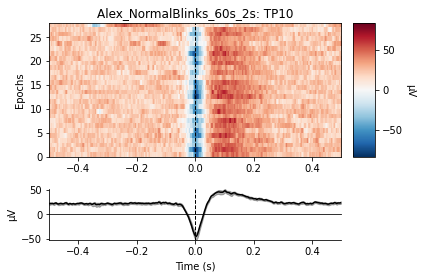

C:\Users\ryanp\AppData\Local\Temp\ipykernel_10688\3333842092.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")


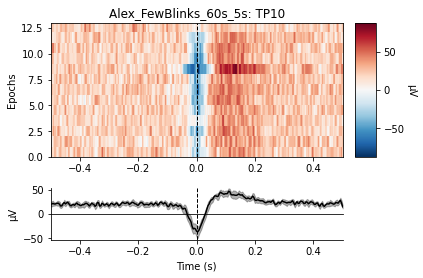

In [8]:
channel_to_plot = "TP10"
for key, dataset in epoched_data.items():
    dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")

There is clearly a general trend in the eyeblinks, Since stacking them up like this shows that the dips in the signal (blue) and rises in the signal (red) happen at roughly the same time with each eyeblink. Since they follow similar patterns, this justifies looking at the *average* signal for each of these blink-types.

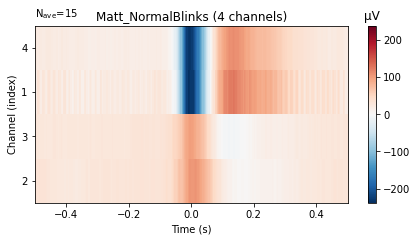

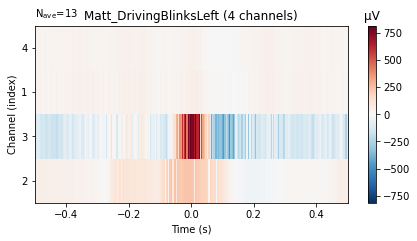

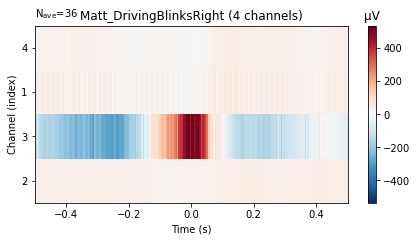

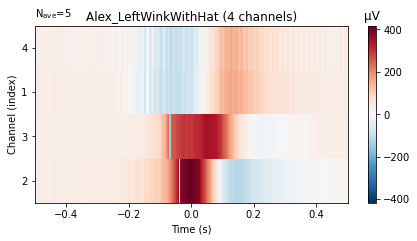

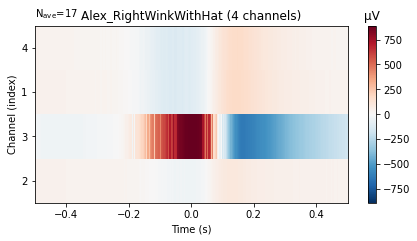

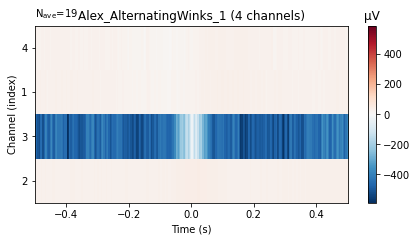

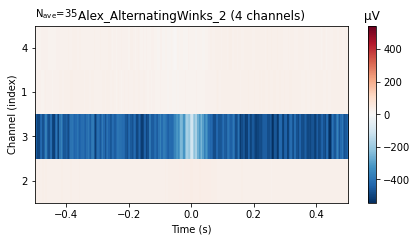

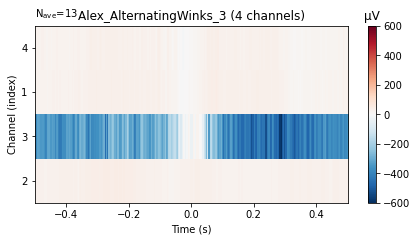

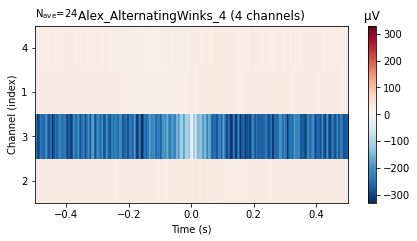

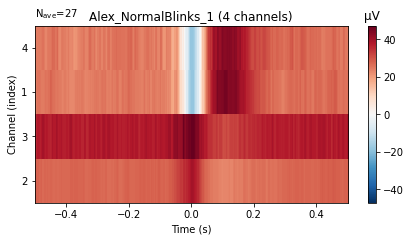

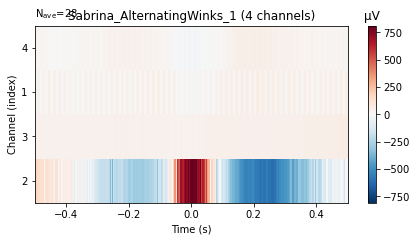

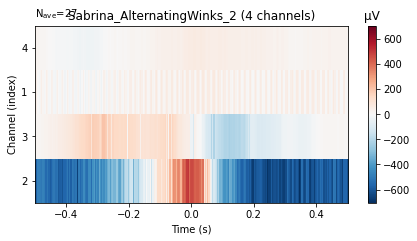

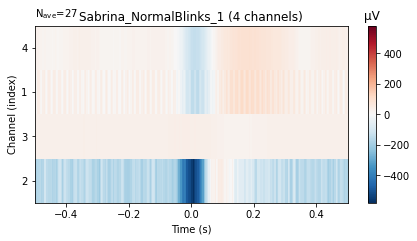

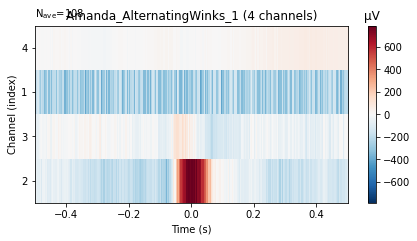

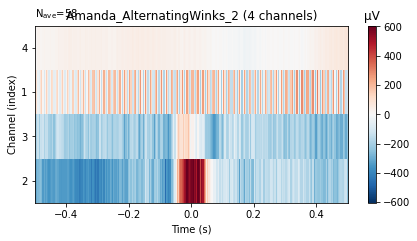

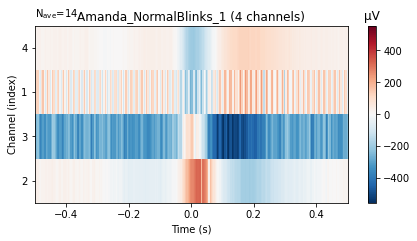

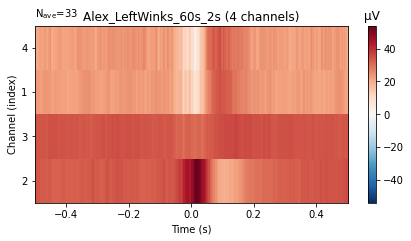

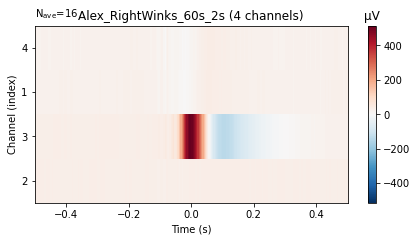

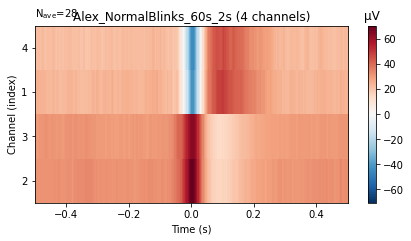

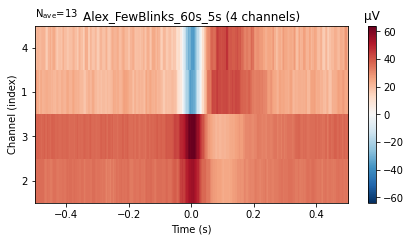

In [9]:
for key, evoked in evoked_data.items():
    evoked.plot_image(picks=["AF7","AF8","TP9","TP10"], titles=key)

These plots show the asymmetry that exists in people's eyeblinks. Despite this, the signals are different, and we should be able to distinguish between left, right, and normal winks. Some approaches to this are tested out below.

## Idea #1: Window Variance

### Explanation of the Idea
We might be able to distinguish between normal and driving blinks using the variance of the signal in a given window. We expect that both normal and driving blinks will lead to large variances on their windows, but driving blinks should have more due to the muscle contractions that are involved with shutting your eye so forcefully. 

### Method
To do this, we need to pick a window size on which to calculate the variance. Since a normal blink takes roughly 200 timesteps, we can use 200 as the window size. For the step length, let's use 1 for now. This will change based on the processing latency when we actually stream data in real-time.

### Results
Below, we find the variance for each window, and plot the variance of a window on the y-axis vs the index of the window's start. Superimposing this variance signal with the eyeblinks shows that it picks up the normal eyeblinks pretty well, but the driving blinks have a messy variance signal.

Also, the hope was that the variance has different peaks between normal and driving blinks. To check this, we plotted a histogram of the peaks in the variance. While the normal blinks have a pretty nicely-distributed peak height, the mix of normal and driving blinks is not as bimodal as we would have hoped. If we see two separate peaks, then we can say that the lower and higher peaks in the distribution of variances correspond to the different kinds of blinks. Unfortunately, we don't see that.

### Future Approach
The fact that this approach doesn't work may be due to the difference in the duration of normal and driving blinks, so on a window that is the size of normal blinks, you'll get good detection of normal blinks but the driving blinks will be split across multiple windows and therefore they won't pop out as much. For windows that are the size of driving blinks, we'll pick up their variance very easily, but normal blinks will get "washed out" since they will only occupy a small fraction of the window.

Matt_NormalBlinks


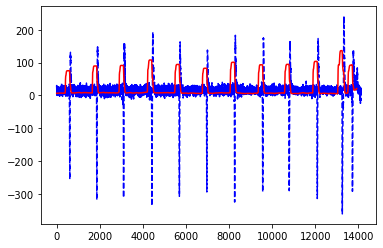

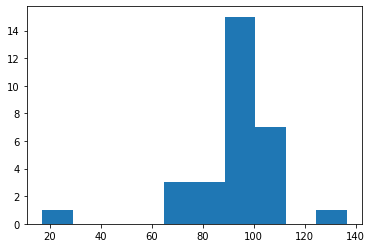

Matt_DrivingBlinksLeft


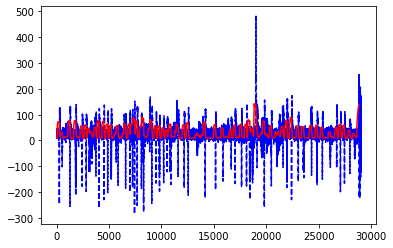

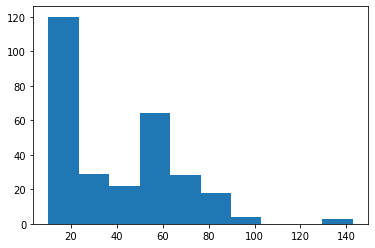

Matt_DrivingBlinksRight


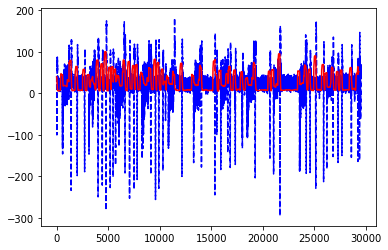

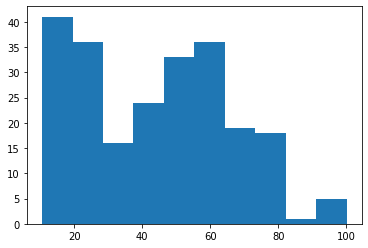

Alex_LeftWinkWithHat


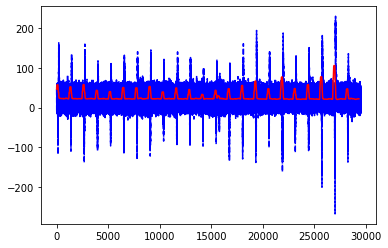

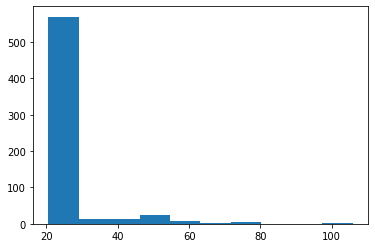

Alex_RightWinkWithHat


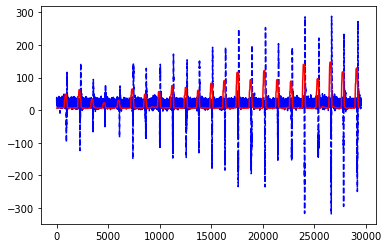

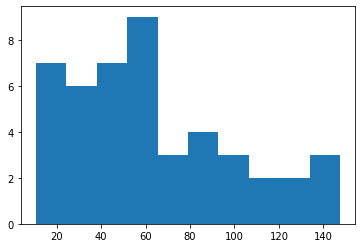

Alex_AlternatingWinks_1


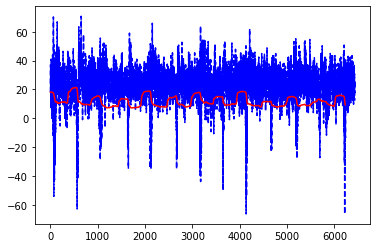

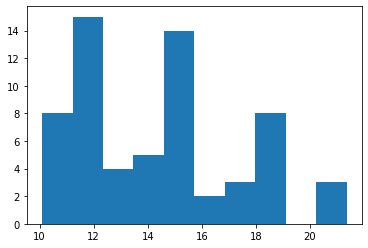

Alex_AlternatingWinks_2


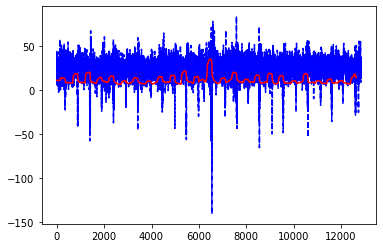

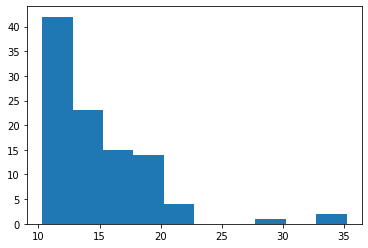

Alex_AlternatingWinks_3


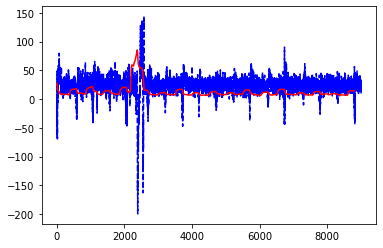

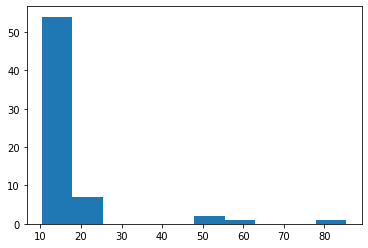

Alex_AlternatingWinks_4


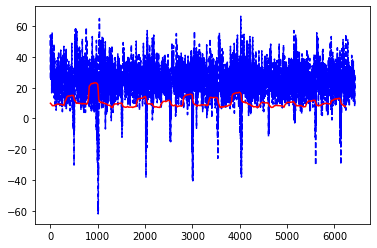

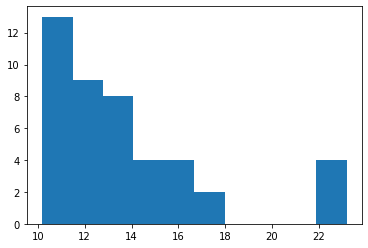

Alex_NormalBlinks_1


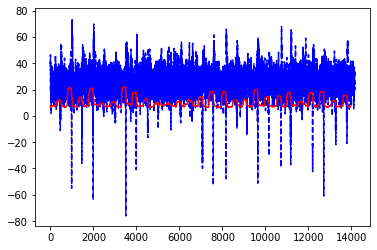

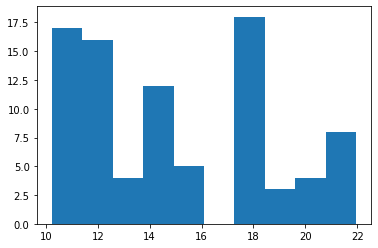

Sabrina_AlternatingWinks_1


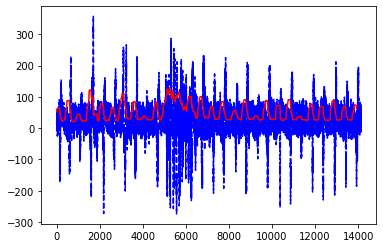

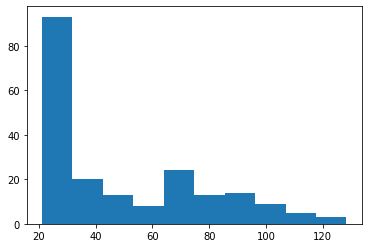

Sabrina_AlternatingWinks_2


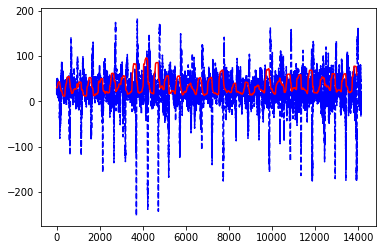

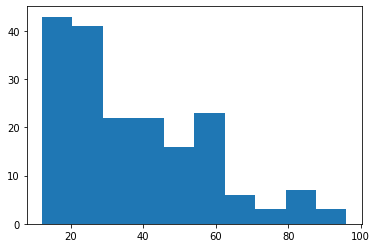

Sabrina_NormalBlinks_1


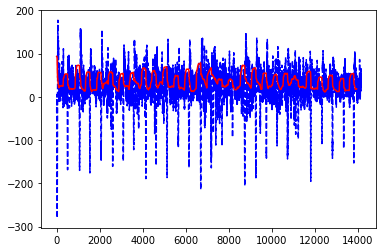

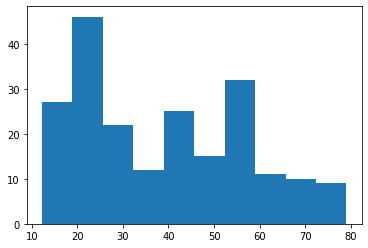

Amanda_AlternatingWinks_1


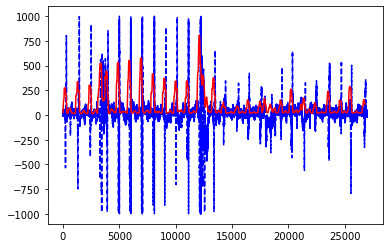

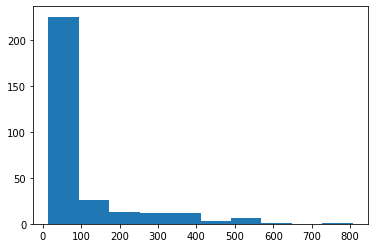

Amanda_AlternatingWinks_2


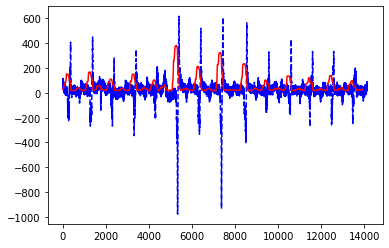

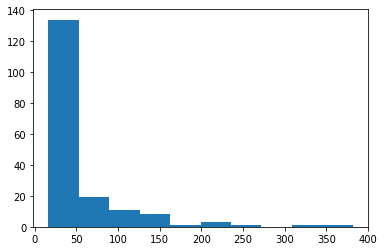

Amanda_NormalBlinks_1


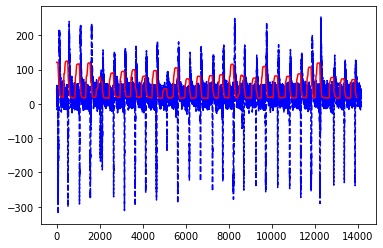

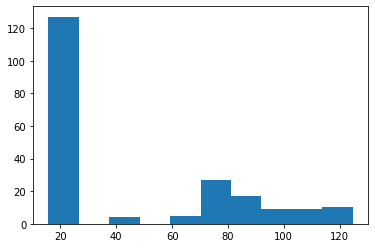

Alex_LeftWinks_60s_2s


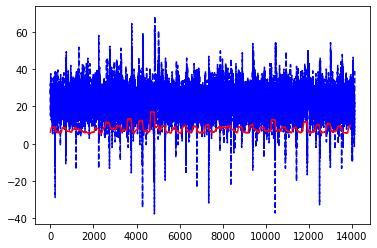

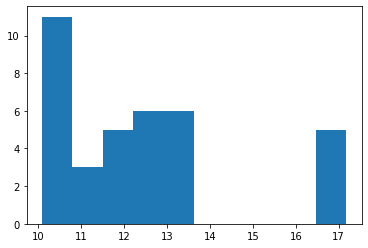

Alex_RightWinks_60s_2s


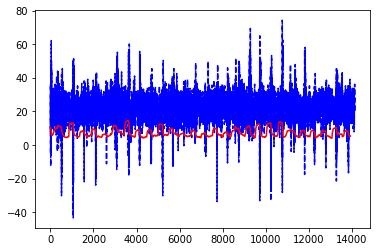

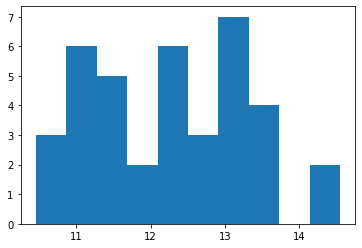

Alex_NormalBlinks_60s_2s


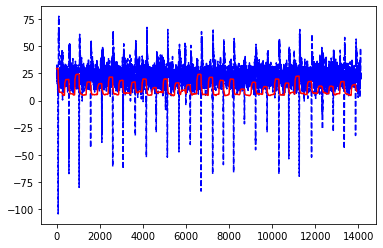

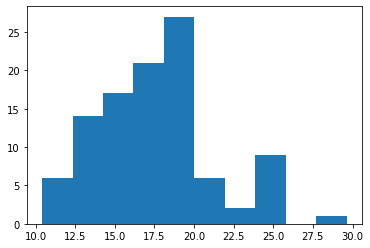

Alex_FewBlinks_60s_5s


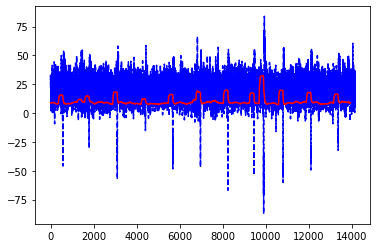

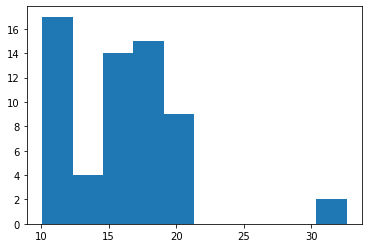

In [10]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
for key, dataset in raw_recordings.items():
    print(key)
    variance_list = []
    for window_start in range(0, dataset["timestamps"].size - 200, 10):
        window_stop = window_start + 200
        channelname = "TP10"
        variance_list.append(np.std(dataset[channelname][window_start:window_stop]))
    #plt.plot(dataset[channelname])
    variance_list = np.array(variance_list)
    non_baseline = variance_list[variance_list > 10]

    plt.plot(dataset[channelname], "--b")
    plt.plot(range(0, dataset["timestamps"].size - 200, 10), variance_list, "r-")

    plt.show()
    plt.hist(non_baseline[signal.argrelextrema(non_baseline, np.greater)[0]])
    plt.show()

## Idea #2: Template-Matching

### Explanation of the Idea
We can use the average left, right, and normal eye-blink as a "template" for what left, right, and normal blinks look like respectively. If we slide this template along the data, we can take a window that is the size of the template and ask how well the template "fits" to the data in that window. In each window, we can predict which kind of blink (if any) is occurring, based on which template fits the data the best.

### Methods
To try this out, we use the evoked potentials from the "Loading in and Preparing the Dataset" section to generate the templates. To see hwo well the templates can distinguish between the different blinks and users, we chose a single template to use on all the recordings. Then, we divide the chosen template by a constant factor 10^6 to account for the conversion from MNE object to pandas dataframe. Since MNE automatically thinks all EEG data is in Volts (and are therefore really small), it converts them to microvolts to make them easier to interpret. In our case, the data is already in microvolts, so MNE scales them up by an extra factor of 10^6 which we don't want. There might be a way to tell MNE to not do this conversion, but I haven't found it yet.

Once we have the template, we slide this template across all channels of the dataset, and and take the chi-squared value in each window. The plots below show the raw data in blue, and the chi-squared value for the *window beginning on that position* in orange. 

### Results
As expected, there is a dip in the chi-squared in the position that corresponds to the start of the window containing the eyeblink. The problem is, that any template tends to produce these dips in any dataset. For example, using Matt_NormalBlinks as the template produces the dips even in Alex_LeftWinksWithHat, albeit more rarely. 

This is likely due to the fact that there is comparable variation between the same blinks/winks from the same person, as the variation between different blinks/winks between different people. So a template fits its own data roughly as well as it fits anyone else's data.

### Future Approach
If the conclusion above is correct, it will likely be a problem for all of our future appraoches too, and should be investigated statistically to see if the claim is correct. In this case, one possible solution is to practice winks so that they are consistent enough that templates from one data set do not work too well on others. In any one person becomes really good at having consistent winks, then their templates will be more specific to them and less likely to work on a different one of their winks.

Alternatively, we could analyze the distributions of the chi-squared values, particularly the minima, to see if maybe the templates do consistently have better fits on their own data than others, just not visibly.

Finally, we can also try using a different approach to see how well the template fits the data. One stragey could be convolution.

In [11]:
# Get the templates out of the data
templates = {key : dataset.to_data_frame(picks=["AF7", "AF8", "TP9", "TP10"]) for key, dataset in evoked_data.items()}

# Go through the data in chunks of size "window_size" and check the chi-squared
# For each channel in "channels" using the corresponding template
step_length = 1
channels = ["TP9", "TP10"]
chi_squareds = {dataset_name: {channel_name : [] for channel_name in channels} for dataset_name in templates.keys()}

# Go through each dataset in the raw_recording dictionary
for key, dataset in raw_recordings.items():
    # Get the window size for this dataset based on the length of the template
    template_to_use = "Alex_RightWinkWithHat"
    window_size = templates[template_to_use]["time"].size
    # Grab the template from the templates dictionary
    template = templates[template_to_use].divide(10**6)
    # Go through the raw_recording in steps of window_size
    for i in range(0, dataset["timestamps"].size - window_size, 1):
        # Get the window
        window = dataset.iloc[i:i+window_size]
        # Apply the template to each channel and store the corresponding chi_squared
        for channel in channels:
            chi_squared = ((window[channel].values - template[channel].values)**2).sum() / window_size**2
            chi_squareds[key][channel].append(chi_squared)

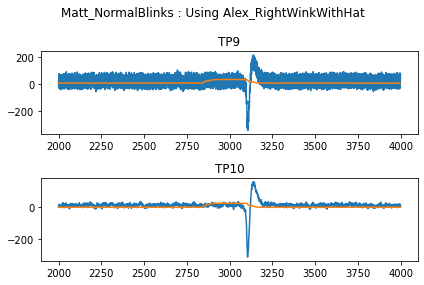

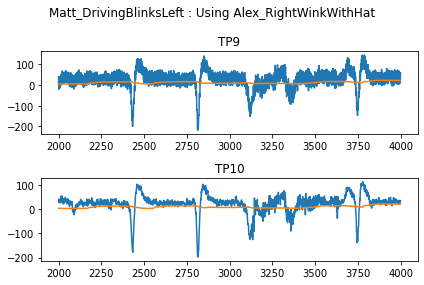

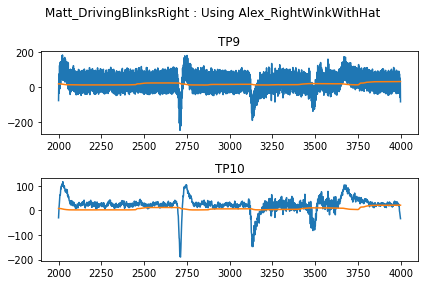

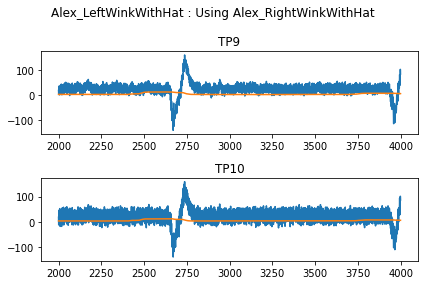

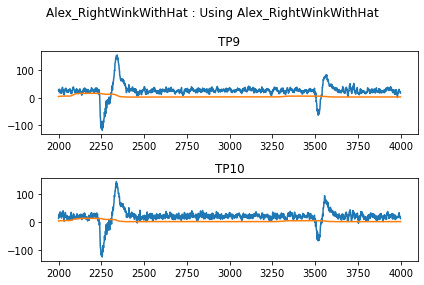

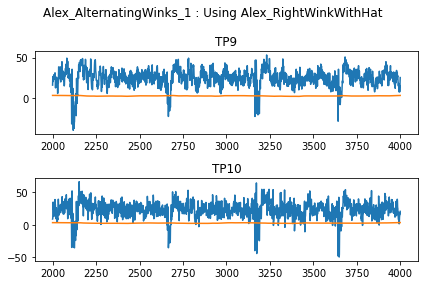

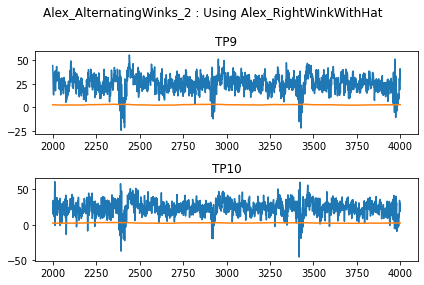

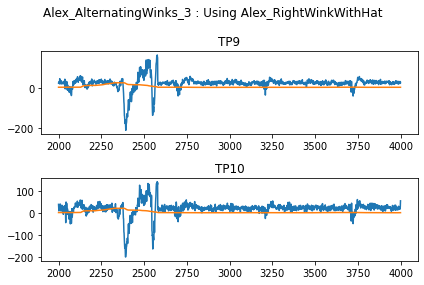

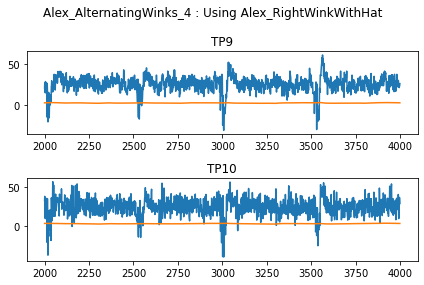

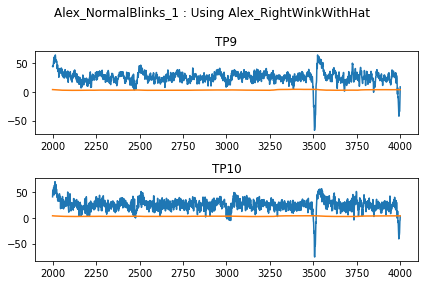

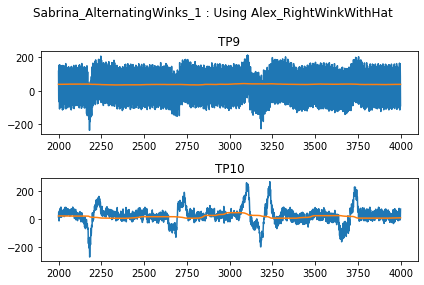

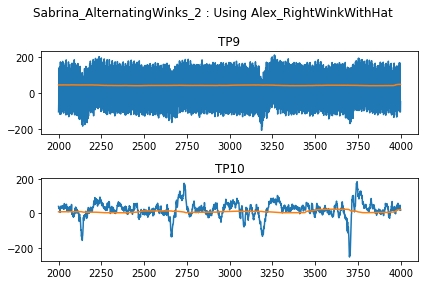

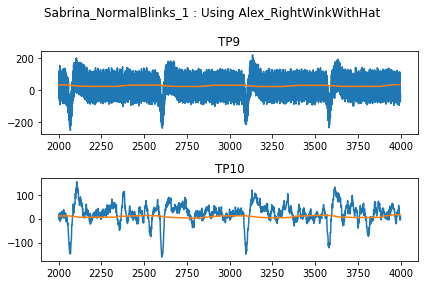

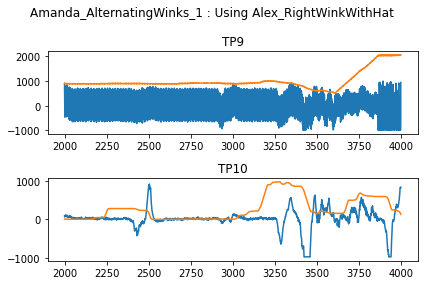

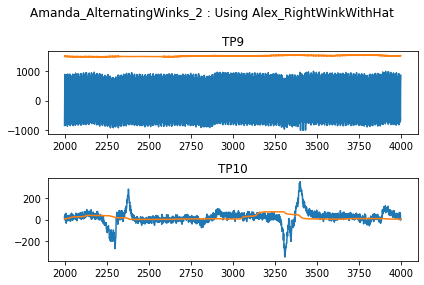

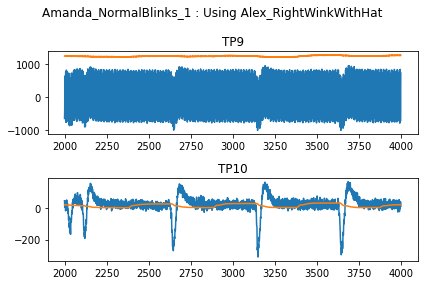

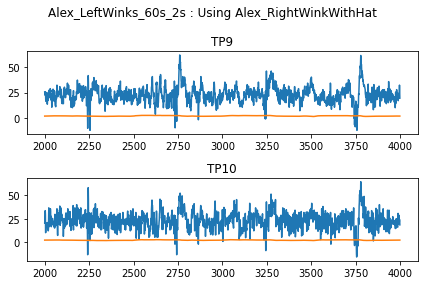

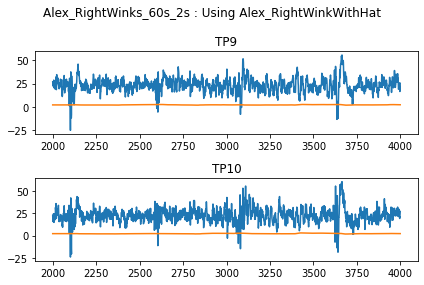

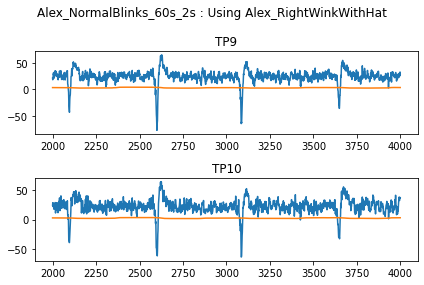

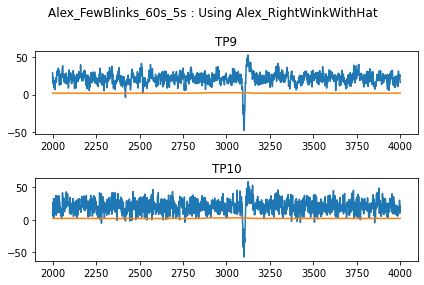

In [12]:
# Plot so we can see how well we distinguish
left = 2000
right = 4000
for key in templates.keys():
    fig, ax = plt.subplots(2,1)
    fig.suptitle(f"{key} : Using {template_to_use}")
    for channel_idx in range(len(channels)):
        channel = channels[channel_idx]
        ax[channel_idx].plot(raw_recordings[key][channel][left:right])
        ax[channel_idx].plot(range(left, right), (np.array(chi_squareds[key][channel]))[left:right])
        ax[channel_idx].set_title(f"{channel}")
    plt.tight_layout()
    plt.show()

## Idea #3: Support Vector Machine
For this approach, we'll combine the previous two approaches together with a support vector machine that will try to learn the distinction between driving winks vs normal blinks vs no blinks. A support vector machine is a good choice because of a few things:

1. We don't have (or want to need) a ton of data to train our model for each user. SVMs have a fairly low-dimensional parameter space.
2. Our data is very high-dimesional. As a start, for each window, we would like to feed the SVM our raw data along with the variance and chi-squared as our input. This is 100+ dimensions.
3. They are fast at classifying, and we can probably use a trained model in real-time as we stream data from the Muse.

To do this, we need 3 datasets per user:
1. Normal blinking
2. Left wink
3. Right wink

Then, we can use mne's built-in `create_eog_events()` function to pull out the blinks in each dataset, and depending on which recording it's from we can label it as either left wink, right wink, or normal blink. Then, we take all the windows in all the datasets that are not blinks, and label them as non-blinks.

The problem is that it's tricky to record left winks and right winks separately, since the other eye needs to be closed and this can lead to signals that are not the same as when the other eye is open. Instead, we can record a dataset that's alternating between left and right winks, and then note the side on which the recording's first wink takes place. From there we can assume that every other peak in the signal is the same-side wink, and do the same as the above.

We re-recorded data from a few of our participants following the procedure above. The following cell demonstrates how to prepare this data for using an ML algorithm.

NOTE: We want to make sure that we don't train our model on any data that it will be tested on. One way that this could happen is if we allow non-blink windows to overlap with each other. Then, if we define a split in our data and use one portion to train and one to test, we may accidentally have windows in our training set that overlap with windows in our testing set. Although it's possible to avoid this problem just by being careful and making sure there is no overlap, we are better off just not having overlapping windows in the first place. The reason is that we already have more examples of non-blink windows in our data than blink windows anyways, and including overlap would mainly increase the number of non-blink windows. This would lead to a very unbalanced dataset, which makes machine learning more difficult. This nuance is all handled inside the utils functions for extracting eyeblinks and non-eyeblinks from the data.

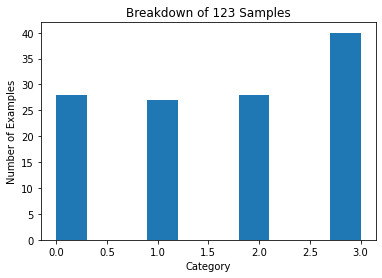

In [4]:
import matplotlib.pyplot as plt
import utils

# Grab data for Alex
user_dataset = {key: raw_data[key] for key in (
    "Alex_LeftWinks_60s_2s", 
    "Alex_RightWinks_60s_2s", 
    "Alex_NormalBlinks_60s_2s", 
    "Alex_FewBlinks_60s_5s"
    )}
X, Y = utils.prepare_data(
    user_dataset=user_dataset, 
    duration_of_blink=1, 
    sampling_frequency=256, 
    duration_before_peak=0.25, 
    jitter=0.1
    )
# Plot the distribution of examples in our dataset
plt.hist(Y)
plt.xlabel("Category")
plt.ylabel("Number of Examples")
plt.title(f"Breakdown of {len(X)} Samples")
plt.show()

Now let's actually try classifying the data using an SVM.

In [26]:
import numpy as np
import seaborn as sns
from sklearn import svm, model_selection, preprocessing, metrics

# Do any necessary preprocessing
print(X[0].values)
X_SVM = np.array([x.values.flatten() for x in X])
Y_SVM = Y

# Do a 3-fold cross-validation to get an idea how the model works on the whole dataset
train_test_splitter = model_selection.KFold(n_splits=2, shuffle=True, random_state=123)
# Fit the classifier on the data
for train_index, test_index in train_test_splitter.split(X_SVM):
    # Initialize the classsifier (you can tweak hyperparameters here)
    classifier = svm.SVC(kernel="linear", probability=True)
    X_train, X_test = X_SVM[train_index], X_SVM[test_index]
    Y_train, Y_test = Y_SVM[train_index], Y_SVM[test_index]
    classifier.fit(X_train, Y_train)
    # Test the classifier's accuracy
    print(f"Classifier Accuracy: {classifier.score(X_test, Y_test)}")
    # Test the classifier's ROC-AUC statistic
    prediction_probabilities = classifier.predict_proba(X_test)
    print(f"Classifier AUC: {metrics.roc_auc_score(y_true=Y_test, y_score=prediction_probabilities, multi_class='ovr')}")
    y_pred = classifier.predict(X_test)
    conf_matrix = metrics.confusion_matrix(Y_test, y_pred)
    sns.heatmap(conf_matrix)
    plt.title("Confusion Matrix (0 - RW | 1 - LW | 2 - NB | 3 - NA)")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.show()

NameError: name 'x' is not defined

Convolutional neural network

In [104]:
import numpy as np
import seaborn as sns
from tensorflow.keras import Sequential, layers, losses, metrics
from tensorflow import one_hot
from sklearn.model_selection import train_test_split

# Do any necessary preprocessing
X_CNN = np.array([x.values for x in X])
Y_CNN = Y

# Train-Test split
X_train, X_test, Y_train, Y_test = train_test_split(X_CNN, Y, train_size=0.75)

Y_train = one_hot(Y_train, 4)
Y_test = one_hot(Y_test, 4)

# Initialize the classsifier (you can tweak hyperparameters here)
model = Sequential()
model.add(layers.Conv1D(100, 50, strides=1, input_shape=(256, 4)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation="sigmoid"))
model.add(layers.Dense(10, activation="relu"))
model.add(layers.Dense(4, activation="softmax"))
model.compile(loss=losses.CategoricalCrossentropy(), metrics=[metrics.Accuracy()])
model.summary()
history = model.fit(X_train, Y_train, batch_size=10, epochs=100)
print(model.predict(X_test) - Y_test)
print(dir(history))
# Test the classifier's accuracy
print(f"Classifier Loss and Accuracy: {model.evaluate(X_test, Y_test, batch_size = 5)}")
    # # Test the classifier's ROC-AUC statistic
    # prediction_probabilities = classifier.predict_proba(X_test)
    # print(f"Classifier AUC: {metrics.roc_auc_score(y_true=Y_test, y_score=prediction_probabilities, multi_class='ovr')}")
    # y_pred = classifier.predict(X_test)
    # conf_matrix = metrics.confusion_matrix(Y_test, y_pred)
    # sns.heatmap(conf_matrix)
    # plt.title("Confusion Matrix (0 - RW | 1 - LW | 2 - NB | 3 - NA)")
    # plt.xlabel("Predicted Class")
    # plt.ylabel("True Class")
    # plt.show()

Model: "sequential_95"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_49 (Conv1D)          (None, 207, 100)          20100     
                                                                 
 max_pooling1d_43 (MaxPoolin  (None, 103, 100)         0         
 g1D)                                                            
                                                                 
 flatten_39 (Flatten)        (None, 10300)             0         
                                                                 
 dense_121 (Dense)           (None, 10)                103010    
                                                                 
 dense_122 (Dense)           (None, 10)                110       
                                                                 
 dense_123 (Dense)           (None, 4)                 44        
                                                     

All we really did was take our raw EEG data from each channel, pull out 256-timepoint (1 second) chunks from each channel, and append them into one long 4*256 long vector, and feed that to our SVM. This is as bare-bones as it gets, but even so the classifier is getting accuracy as high as 95%. It's even still doing around 90% if you introduce significant jitter in the eyeblink's location within the windows, which is our way of simulating real data. I expect that there are many ways to improve this further, but for now, let's check to see how the classifier performs on some real data.

The code below starts a stream with the first nearby Muse it detects, and streams the data into a buffer that we can pull chunks out of continuously to analyze the data. The code is an adapted version from an example within `muselsl`, which you can see here: https://github.com/alexandrebarachant/muse-lsl/blob/master/examples/neurofeedback.py 

In [25]:
# -*- coding: utf-8 -*-
"""
Estimate Relaxation from Band Powers
This example shows how to buffer, epoch, and transform EEG data from a single
electrode into values for each of the classic frequencies (e.g. alpha, beta, theta)
Furthermore, it shows how ratios of the band powers can be used to estimate
mental state for neurofeedback.
The neurofeedback protocols described here are inspired by
*Neurofeedback: A Comprehensive Review on System Design, Methodology and Clinical Applications* by Marzbani et. al
Adapted from https://github.com/NeuroTechX/bci-workshop
"""

import numpy as np  # Module that simplifies computations on matrices
import matplotlib.pyplot as plt  # Module used for plotting
from pylsl import StreamInlet, resolve_byprop  # Module to receive EEG data
import muselsl_utils as utils  # Our own utility functions

# Handy little enum to make code more readable
class Band:
    Delta = 0
    Theta = 1
    Alpha = 2
    Beta = 3


""" EXPERIMENTAL PARAMETERS """
# Modify these to change aspects of the signal processing

# Length of the EEG data buffer (in seconds)
# This buffer will hold last n seconds of data and be used for calculations
BUFFER_LENGTH = 5

# Length of the epochs used to compute the FFT (in seconds)
EPOCH_LENGTH = 1

# Amount of overlap between two consecutive epochs (in seconds)
OVERLAP_LENGTH = 0.9

# Amount to 'shift' the start of each next consecutive epoch
SHIFT_LENGTH = EPOCH_LENGTH - OVERLAP_LENGTH

# Index of the channel(s) (electrodes) to be used
# 0 = left ear, 1 = left forehead, 2 = right forehead, 3 = right ear
INDEX_CHANNEL = [0, 1, 2, 3]

if __name__ == "__main__":

    """ 1. CONNECT TO EEG STREAM """

    # Search for active LSL streams
    print('Looking for an EEG stream...')
    streams = resolve_byprop('type', 'EEG', timeout=2)
    if len(streams) == 0:
        raise RuntimeError('Can\'t find EEG stream.')

    # Set active EEG stream to inlet and apply time correction
    print("Start acquiring data")
    inlet = StreamInlet(streams[0], max_chunklen=12)
    eeg_time_correction = inlet.time_correction()

    # Get the stream info and description
    info = inlet.info()
    description = info.desc()

    # Get the sampling frequency
    # This is an important value that represents how many EEG data points are
    # collected in a second. This influences our frequency band calculation.
    # for the Muse 2016, this should always be 256
    fs = int(info.nominal_srate())

    """ 2. INITIALIZE BUFFERS """

    # Initialize raw EEG data buffer - 256*5 x 4 array to store the last 5 seconds
    eeg_buffer = np.zeros((int(fs * BUFFER_LENGTH), 4))
    filter_state = None  # for use with the notch filter

    # Compute the number of epochs in "buffer_length"
    n_win_test = int(np.floor((BUFFER_LENGTH - EPOCH_LENGTH) /
                              SHIFT_LENGTH + 1))

    # Initialize the band power buffer (for plotting)
    # bands will be ordered: [delta, theta, alpha, beta]
    band_buffer = np.zeros((n_win_test, 4))

    """ 3. GET DATA """

    # The try/except structure allows to quit the while loop by aborting the
    # script with <Ctrl-C>
    print('Press Ctrl-C in the console to break the while loop.')

    try:
        # The following loop acquires data, computes band powers, and calculates neurofeedback metrics based on those band powers
        while True:

            """ 3.1 ACQUIRE DATA """
            # Obtain EEG data from the LSL stream
            eeg_data, timestamp = inlet.pull_chunk(
                timeout=1, max_samples=int(SHIFT_LENGTH * fs))

            # Only keep the channel we're interested in
            ch_data = np.array(eeg_data)[:, 0:4]

            # Update EEG buffer with the new data
            eeg_buffer, filter_state = utils.update_buffer(
                eeg_buffer, ch_data, notch=False,
                filter_state=filter_state)

            """ 3.2 COMPUTE BAND POWERS """
            # Get newest samples from the buffer
            data_epoch = utils.get_last_data(eeg_buffer,
                                             EPOCH_LENGTH * fs)

            #print('Alpha Relaxation: ', alpha_metric)
            print(data_epoch.shape)

            # Beta Protocol:
            # Beta waves have been used as a measure of mental activity and concentration
            # This beta over theta ratio is commonly used as neurofeedback for ADHD
            # beta_metric = smooth_band_powers[Band.Beta] / \
            #     smooth_band_powers[Band.Theta]
            # print('Beta Concentration: ', beta_metric)

            # Alpha/Theta Protocol:
            # This is another popular neurofeedback metric for stress reduction
            # Higher theta over alpha is supposedly associated with reduced anxiety
            # theta_metric = smooth_band_powers[Band.Theta] / \
            #     smooth_band_powers[Band.Alpha]
            # print('Theta Relaxation: ', theta_metric)

    except KeyboardInterrupt:
        print('Closing!')

Looking for an EEG stream...
Start acquiring data
Press Ctrl-C in the console to break the while loop.
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 4)
(256, 